# <center> ${\text{Data 606 Capstone Project: Manufacturing}}$

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
# Regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN

np.random.seed(12)
#import warnings

#warnings.filterwarnings('ignore')

#### Import files using pandas

In [2]:
train02 = pd.read_csv('01_M02_DC_train.csv')
ttf = pd.read_csv('01_M02_DC_train_ttf.csv')
fault = pd.read_csv('01_M02_train_fault_data.csv')

Rename data columns in TTF and view data. 

In [3]:
ttf = ttf.rename({'TTF_FlowCool Pressure Dropped Below Limit':'Flowcool_Pressure_dropped_below_limit'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool Pressure Too High Check Flowcool Pump':'Flowcool_Pressure_Too_High'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool leak':'TTF_Flowcool_leak'}, axis='columns')

In [4]:
train02.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-1.751661,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-1.747158,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-1.747158,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785


In [5]:
ttf.head()

,time,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


#### Merge the data. 

In [6]:
alldata = pd.merge(train02, ttf, how='outer', on='time')

#### Create new features 

Create new features for the four different scenarios used in classification for Fault 2 - Flowcool Pressure Too High. Below are the lower limits the uppper limits define later. 

In [7]:
numlimit1 = 600
numlimit2 = 2400
numlimit3 = 3600
numlimit4 = 20000

In [8]:
alldata['fault1_a'] = alldata['Flowcool_Pressure_Too_High'].apply(lambda x:1 if x <= numlimit1 else 0)
alldata['fault1_b'] = alldata['Flowcool_Pressure_Too_High'].apply(lambda x:1 if x <= numlimit2 else 0)
alldata['fault1_c'] = alldata['Flowcool_Pressure_Too_High'].apply(lambda x:1 if x <= numlimit3 else 0)
alldata['fault1_d'] = alldata['Flowcool_Pressure_Too_High'].apply(lambda x:1 if x <= numlimit3 else 0)

In [9]:
alldata.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak,fault1_a,fault1_b,fault1_c,fault1_d
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,2.871511,3.175941,4.037785,623234.0,9146470.0,632514.0,0,0,0,0
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,2.871511,3.175941,4.037785,623230.0,9146466.0,632510.0,0,0,0,0
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,2.871511,3.175941,4.037785,623226.0,9146462.0,632506.0,0,0,0,0
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,2.871511,3.175941,4.037785,623222.0,9146458.0,632502.0,0,0,0,0
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,2.871511,3.175941,4.037785,623218.0,9146454.0,632498.0,0,0,0,0


## Classification

- For each scenario the upper limit is define for Fault 2 - Flowcool Pressure Too High.
- The Random Forest, Gradient Boosting Classifier and the Logistic Regression are run. 
- The models for each scenario are compared. 
- SMOTEENN for the Logistic Regression Scenario 1.

###  Scenario 1: Limit is 10800 and isfailure is 600 - 3 hours, 10 minutes

In [10]:
cl_f1a_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit', 'TTF_Flowcool_leak',
                       'fault1_b', 'fault1_c','fault1_d'], axis=1)

In [11]:
clf1data = cl_f1a_data.dropna()

In [12]:
cutoff_1a = 10800

cl_cutoff1a = clf1data.loc[clf1data['Flowcool_Pressure_Too_High']<cutoff_1a].copy()

In [13]:
cl_X1a = cl_cutoff1a.drop(['Flowcool_Pressure_Too_High', 'fault1_a'], axis=1)
cl_Y1a = cl_cutoff1a['fault1_a']

In [19]:
cl_X1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
1354347,11094910,0.004714,-0.952388,0.569103,0.898021,-0.053538,0.360776,0.022131,-0.122446,1.0,-0.263274,0.021044
1354348,11094910,0.004714,-0.952388,0.566387,0.898021,-0.053538,0.360776,0.022131,-0.122446,1.0,-0.263270,0.021044
1354349,11094910,0.004714,-0.952274,0.566387,0.898021,-0.066554,0.350789,0.022131,-0.122446,1.0,-0.263267,0.021044
1354350,11094910,0.004714,-0.952501,0.564421,0.898021,-0.066554,0.350789,0.022131,-0.122446,1.0,-0.263264,0.021044
1354351,11094910,0.004714,-0.952388,0.564421,0.898021,-0.066554,0.364281,0.022131,-0.122446,1.0,-0.263260,0.021044


In [20]:
cl_Y1a.value_counts()

0    5647
1     753
Name: fault1_a, dtype: int64

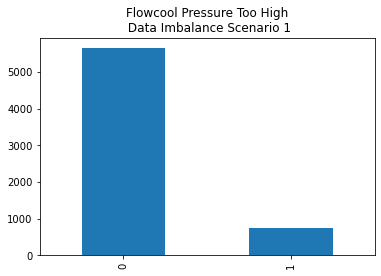

In [40]:
cl_Y1a.value_counts().plot(kind='bar')
plt.title("Flowcool Pressure Too High\n Data Imbalance Scenario 1")
plt.xticks()
plt.show()

In [22]:
X_train1a, X_test1a, Y_train1a, Y_test1a = train_test_split(cl_X1a, cl_Y1a, test_size = 0.2, random_state=42)

In [23]:
X_train1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
2582466,11744123,0.019089,-0.947496,0.567441,0.556676,-0.060052,0.358499,0.022131,-0.122446,1.0,-1.475801,0.021044
2583845,11744123,0.020768,-0.945506,0.565479,0.618377,-0.060052,0.352016,-0.200727,-0.122446,1.0,-1.471658,-0.291949
2784408,11817473,0.010094,-0.949885,0.563367,0.548313,-0.056795,0.357450,0.022131,-0.122455,1.0,-0.846892,0.021044
2583253,11744123,0.020768,-0.944596,0.563367,0.577889,-0.050292,0.364281,-0.200727,-0.122446,1.0,-1.473622,-0.291949
2784905,11817473,0.019089,1.189268,0.580726,0.568873,-0.055042,0.362004,0.022131,-0.122455,1.0,-0.845245,0.803526


In [24]:
cl_scalar = MinMaxScaler()
cl_scalar.fit(X_train1a)

scl_trainX1a = cl_scalar.transform(X_train1a)
scl_testX1a = cl_scalar.transform(X_test1a)

#### Random Forest Classifier A

In [25]:
rfc_a = RandomForestClassifier(random_state=42)

rfc_a.fit(scl_trainX1a, Y_train1a)

RandomForestClassifier(random_state=42)

In [26]:
rfc_pred_a = rfc_a.predict(scl_testX1a)

rfc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('Accuracy Score Random Forest Scenario 1:{:.3f}\n'.format(rfc_accuracy_a))
print('Classification Report Random Forest Scenario 1\n\n',classification_report(Y_test1a, rfc_pred_a))

Accuracy Score Random Forest Scenario 1:0.998

Classification Report Random Forest Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      0.99      0.99       154

    accuracy                           1.00      1280
   macro avg       1.00      0.99      1.00      1280
weighted avg       1.00      1.00      1.00      1280



In [27]:
rfc_cm = confusion_matrix(Y_test1a, rfc_pred_a)

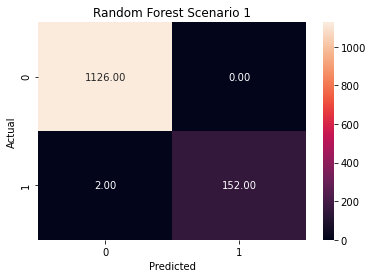

In [28]:
sns.heatmap(rfc_cm, annot=True, fmt='.2f')
plt.title('Random Forest Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier  A

In [29]:
gbc_a = GradientBoostingClassifier(random_state=42)

gbc_a.fit(scl_trainX1a, Y_train1a)

GradientBoostingClassifier(random_state=42)

In [32]:
gbc_pred_a = gbc_a.predict(scl_testX1a)

gbc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('Accuracy Score Gradient Boost Classifier Scenario 1:{:.3f}\n'.format(gbc_accuracy_a))
print('Classification Report Gradient Boost Classifier Scenario 1\n\n', classification_report(Y_test1a, gbc_pred_a))

Accuracy Score Gradient Boost Classifier Scenario 1:0.998

Classification Report Gradient Boost Classifier Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      0.99      1.00       154

    accuracy                           1.00      1280
   macro avg       1.00      1.00      1.00      1280
weighted avg       1.00      1.00      1.00      1280



In [33]:
gbc_cm = confusion_matrix(Y_test1a, gbc_pred_a)

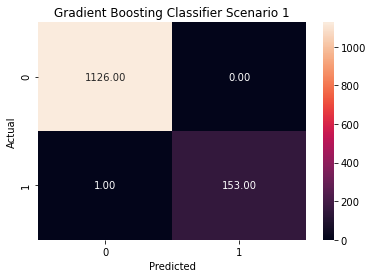

In [34]:
sns.heatmap(gbc_cm, annot=True, fmt='.2f')
plt.title('Gradient Boosting Classifier Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression A

In [35]:
logreg_a = LogisticRegression()

logreg_a.fit(scl_trainX1a, Y_train1a)

LogisticRegression()

In [36]:
logreg_pred_a = logreg_a.predict(scl_testX1a)

logreg_accuracy_a = accuracy_score(Y_test1a, logreg_pred_a)

print('Accuracy Score Logistic Regression Scenario 1:{:.3f}\n'.format(logreg_accuracy_a))
print('Classification Report Logistic Regression Scenario 1\n\n', classification_report(Y_test1a, logreg_pred_a))

Accuracy Score Logistic Regression Scenario 1:0.914

Classification Report Logistic Regression Scenario 1

               precision    recall  f1-score   support

           0       0.93      0.98      0.95      1126
           1       0.72      0.47      0.57       154

    accuracy                           0.91      1280
   macro avg       0.83      0.72      0.76      1280
weighted avg       0.91      0.91      0.91      1280



#### Cross Validation A

In [41]:
rfc_valscore_a = cross_validate(rfc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].std()))

Scores:0.992
Scores:0.003


In [42]:
gbc_valscore_a = cross_validate(gbc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].std()))

Scores:0.993
Scores:0.003


In [43]:
logreg_valscore_a = cross_validate(logreg_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].std()))

Scores:0.562
Scores:0.050


#### Fine Tune Parameters

#### Fine Tuning the Random Forest Classifier

Different hyperparameters are tried out using GridSearchCV to improve performance.

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
rfc_grid = [{'n_estimators':[50,200], 'max_depth':[5,10], 'criterion':['entropy','gini']}]

rfc_cv = RandomForestClassifier()

In [46]:
rfc_gridsearch= GridSearchCV(estimator =rfc_cv, param_grid=rfc_grid, cv=5, return_train_score=True )

rfc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 10], 'n_estimators': [50, 200]}],
             return_train_score=True)

In [47]:
rfc_gridsearch.best_score_

0.9986328125

In [48]:
rfc_best = rfc_gridsearch.best_estimator_

In [49]:
rfc_best_a = rfc_best.predict(scl_testX1a)

rfc_best_accuracy_a = accuracy_score(Y_test1a, rfc_best_a)

print('Accuracy Score Random Forest after fine tuning Scenario 1:{:.3f}\n'.format(rfc_best_accuracy_a))
print('Classification Report Random Forest after fine tuning Scenario 1\n\n', classification_report(Y_test1a, rfc_best_a))

Accuracy Score Random Forest after fine tuning Scenario 1:0.998

Classification Report Random Forest after fine tuning Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      0.99      0.99       154

    accuracy                           1.00      1280
   macro avg       1.00      0.99      1.00      1280
weighted avg       1.00      1.00      1.00      1280



#### Fine Tuning the Gradient Boosting Classifier

In [50]:
gbc_grid = [{'n_estimators':[50,150], 'max_depth':[2,5]}]

gbc_cv = GradientBoostingClassifier()

In [51]:
gbc_gridsearch= GridSearchCV(estimator = gbc_cv, param_grid=gbc_grid, cv=5, return_train_score=True )

gbc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid=[{'max_depth': [2, 5], 'n_estimators': [50, 150]}],
             return_train_score=True)

In [52]:
gbc_gridsearch.best_score_

0.9984375

In [53]:
gbc_best = gbc_gridsearch.best_estimator_

In [54]:
gbc_best_a = gbc_best.predict(scl_testX1a)

gbc_best_accuracy_a = accuracy_score(Y_test1a, gbc_best_a)

print('Accuracy Score Gradient Boosting Classifier after fine tuning Scenario 1:  {:.3f}\n'.format(gbc_best_accuracy_a))
print('Classification Report Gradient Boosting Classifier after fine tuning Scenario 1\n\n', classification_report(Y_test1a, gbc_best_a))

Accuracy Score Gradient Boosting Classifier after fine tuning Scenario 1:  0.999

Classification Report Gradient Boosting Classifier after fine tuning Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      0.99      1.00       154

    accuracy                           1.00      1280
   macro avg       1.00      1.00      1.00      1280
weighted avg       1.00      1.00      1.00      1280



#### Fine Tuning Logistic Regression

In [55]:
grid = [{'C':[0.01,0.1,1], 'penalty':['l1'],'solver':['liblinear']},
        {'C':[0.01,0.1,1], 'penalty':['l2'],'solver':['lbfgs']}]
         
logreg_cv = LogisticRegression(random_state=7, max_iter=200)

In [56]:
logreg_gridsearch = GridSearchCV(estimator =logreg_cv, param_grid=grid, cv=5, return_train_score=True )

logreg_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=7),
             param_grid=[{'C': [0.01, 0.1, 1], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             return_train_score=True)

In [57]:
logreg_gridsearch.best_score_

0.916796875

In [58]:
logreg_gridsearch.best_estimator_

LogisticRegression(C=1, max_iter=200, random_state=7)

In [59]:
logreg_bestest =logreg_gridsearch.best_estimator_

In [60]:
logreg_best_a = logreg_bestest.predict(scl_testX1a)

logreg_best_accuracy_a = accuracy_score(Y_test1a, logreg_best_a)

print('Accuracy Score Logistic Regression after fine tuning Scenario 1:{:.3f}\n'.format(logreg_best_accuracy_a))
print('Classification Report Logistic Regression after fine tuning Scenario 1\n\n', classification_report(Y_test1a, logreg_best_a))

Accuracy Score Logistic Regression after fine tuning Scenario 1:0.914

Classification Report Logistic Regression after fine tuning Scenario 1

               precision    recall  f1-score   support

           0       0.93      0.98      0.95      1126
           1       0.72      0.47      0.57       154

    accuracy                           0.91      1280
   macro avg       0.83      0.72      0.76      1280
weighted avg       0.91      0.91      0.91      1280



In [61]:
logreg_cm = confusion_matrix(Y_test1a, logreg_best_a)

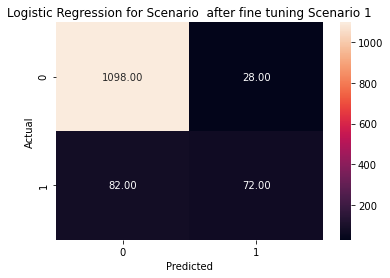

In [62]:
sns.heatmap(logreg_cm, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario  after fine tuning Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Scenario 2: Limit is 19800 and failure is 2400 - 5 1/2 hours, 40 minutes

In [64]:
cl_f1b_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit','TTF_Flowcool_leak',
                       'fault1_a', 'fault1_c','fault1_d'], axis=1)

In [65]:
clf1data_b = cl_f1b_data.dropna()

In [66]:
cutoff_1b = 19800

cl_cutoff1b = clf1data_b.loc[clf1data_b ['Flowcool_Pressure_Too_High']<cutoff_1b].copy()

In [67]:
cl_X1b = cl_cutoff1b.drop(['Flowcool_Pressure_Too_High', 'fault1_b'], axis=1)
cl_Y1b = cl_cutoff1b['fault1_b']

In [68]:
cl_X1b.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
1353418,11094910,-0.079525,-0.958701,-2.841850,-2.332807,-1.751661,-2.787718,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353419,11094910,-0.079520,-0.959042,-2.842907,-2.332807,-1.756665,-2.787718,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353420,11094910,-0.079520,-0.958758,-2.842907,-2.332807,-1.756665,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353421,11094910,-0.079525,-0.958928,-2.840944,-2.332807,-1.754914,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353422,11094910,-0.079538,-0.959042,-2.840944,-2.332807,-1.754914,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197


In [69]:
cl_Y1b.value_counts()

0    5265
1    2218
Name: fault1_b, dtype: int64

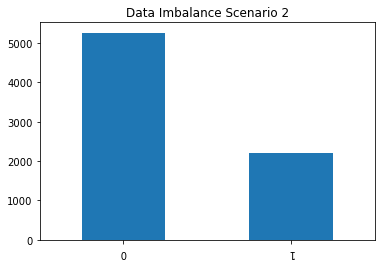

In [70]:
cl_Y1b.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 2")
plt.xticks(rotation=180)
plt.show()

In [71]:
X_train1b, X_test1b, Y_train1b, Y_test1b = train_test_split(cl_X1b, cl_Y1b, test_size = 0.2, random_state=42)

In [72]:
cl_scalar_b = MinMaxScaler()
cl_scalar_b.fit(X_train1b)

scl_trainX1b = cl_scalar.transform(X_train1b)
scl_testX1b = cl_scalar.transform(X_test1b)

#### Random Forest Classifier B

In [73]:
rfc_b = RandomForestClassifier(random_state=42)

rfc_b.fit(scl_trainX1b, Y_train1b)

RandomForestClassifier(random_state=42)

In [74]:
rfc_pred_b = rfc_b.predict(scl_testX1b)

rfc_accuracy_b = accuracy_score(Y_test1b, rfc_pred_b)

print('Accuracy Score Random Forest Scenario 2:{:.3f}\n'.format(rfc_accuracy_b))
print('Classification Report Random Forest Scenario 2\n\n',classification_report(Y_test1b, rfc_pred_b))

Accuracy Score Random Forest Scenario 2:0.999

Classification Report Random Forest Scenario 2

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1068
           1       1.00      1.00      1.00       429

    accuracy                           1.00      1497
   macro avg       1.00      1.00      1.00      1497
weighted avg       1.00      1.00      1.00      1497



In [75]:
rfc_cm_b = confusion_matrix(Y_test1b, rfc_pred_b)

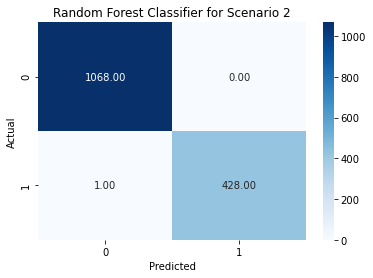

In [76]:
sns.heatmap(rfc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Random Forest Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier B

In [77]:
gbc_b = GradientBoostingClassifier()

gbc_b.fit(scl_trainX1b, Y_train1b)

GradientBoostingClassifier()

In [78]:
gbc_pred_b = gbc_b.predict(scl_testX1b)

gbc_accuracy_b = accuracy_score(Y_test1b, gbc_pred_b)

print('Accuracy Score Gradient Boost Classifier Scenario 2:{:.3f}\n'.format(gbc_accuracy_b))
print('Classification Report Gradient Boost Classifier Scenario 2\n\n', classification_report(Y_test1b, gbc_pred_b))

Accuracy Score Gradient Boost Classifier Scenario 2:0.999

Classification Report Gradient Boost Classifier Scenario 2

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1068
           1       1.00      1.00      1.00       429

    accuracy                           1.00      1497
   macro avg       1.00      1.00      1.00      1497
weighted avg       1.00      1.00      1.00      1497



In [79]:
gbc_cm_b = confusion_matrix(Y_test1b, gbc_pred_b)

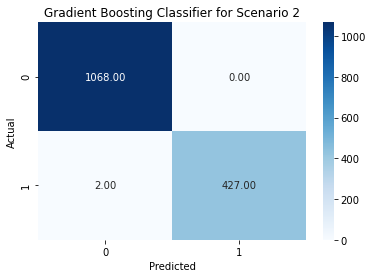

In [80]:
sns.heatmap(gbc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression B

In [81]:
logreg_b = LogisticRegression()

logreg_b.fit(scl_trainX1b, Y_train1b)

LogisticRegression()

In [82]:
logreg_pred_b = logreg_b.predict(scl_testX1b)

logreg_accuracy_b = accuracy_score(Y_test1b, logreg_pred_b)

print('Accuracy Score Logistic Regression Scenario 2: {:.3f}\n'.format(logreg_accuracy_b))
print('Classification Report Logistic Regression Scenario 2\n\n', classification_report(Y_test1b, logreg_pred_b))

Accuracy Score Logistic Regression Scenario 2: 0.882

Classification Report Logistic Regression Scenario 2

               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1068
           1       0.76      0.86      0.81       429

    accuracy                           0.88      1497
   macro avg       0.85      0.88      0.86      1497
weighted avg       0.89      0.88      0.88      1497



In [83]:
logreg_cm_b = confusion_matrix(Y_test1b, logreg_pred_b)

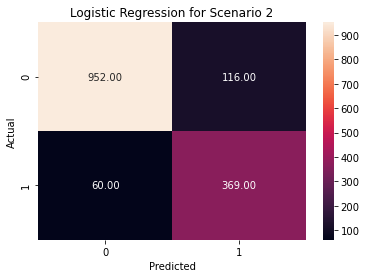

In [84]:
sns.heatmap(logreg_cm_b, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation B

In [85]:
rfc_valscore_b = cross_validate(rfc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].std()))

Scores:0.998
Scores:0.002


In [86]:
gbc_valscore_b = cross_validate(gbc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].std()))

Scores:0.997
Scores:0.002


In [87]:
logreg_valscore_b = cross_validate(logreg_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].std()))

Scores:0.794
Scores:0.013


### Scenario 3: Limit is 28800 and failure is 3600 - 8 hours, 1 hour

In [88]:
cl_f1c_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit', 'TTF_Flowcool_leak',
                       'fault1_a', 'fault1_b','fault1_d'], axis=1)

In [89]:
clf1data_c = cl_f1c_data.dropna()

In [90]:
cutoff_1c = 28800

cl_cutoff1c = clf1data_c.loc[clf1data_c['Flowcool_Pressure_Too_High']<cutoff_1c].copy()

In [91]:
cl_X1c = cl_cutoff1c.drop(['Flowcool_Pressure_Too_High', 'fault1_c'], axis=1)
cl_Y1c = cl_cutoff1c['fault1_c']

In [92]:
cl_X1c.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
1353418,11094910,-0.079525,-0.958701,-2.841850,-2.332807,-1.751661,-2.787718,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353419,11094910,-0.079520,-0.959042,-2.842907,-2.332807,-1.756665,-2.787718,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353420,11094910,-0.079520,-0.958758,-2.842907,-2.332807,-1.756665,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353421,11094910,-0.079525,-0.958928,-2.840944,-2.332807,-1.754914,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197
1353422,11094910,-0.079538,-0.959042,-2.840944,-2.332807,-1.754914,-2.791223,2.027848,-0.122455,0.0,-0.266154,-0.370197


In [93]:
cl_Y1c.value_counts()

0    5620
1    2788
Name: fault1_c, dtype: int64

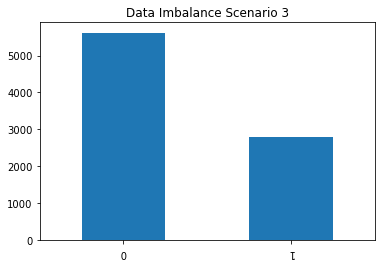

In [94]:
cl_Y1c.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 3")
plt.xticks(rotation=180)
plt.show()

In [95]:
X_train1c, X_test1c, Y_train1c, Y_test1c = train_test_split(cl_X1c, cl_Y1c, test_size = 0.2, random_state=42)

In [96]:
cl_scalar_c = MinMaxScaler()
cl_scalar_c.fit(X_train1c)

scl_trainX1c = cl_scalar.transform(X_train1c)
scl_testX1c = cl_scalar.transform(X_test1c)

#### Random Forest Classifier C

In [97]:
rfc_c = RandomForestClassifier()

rfc_c.fit(scl_trainX1c, Y_train1c)

RandomForestClassifier()

In [98]:
rfc_pred_c = rfc_c.predict(scl_testX1c)

rfc_accuracy_c = accuracy_score(Y_test1c, rfc_pred_c)

print('Accuracy Score Random Forest Classifier Scenario 3: {:.3f}\n'.format(rfc_accuracy_c))
print('Classification Report Random Forest Classifier Scenario 3\n\n',classification_report(Y_test1c, rfc_pred_c))

Accuracy Score Random Forest Classifier Scenario 3: 1.000

Classification Report Random Forest Classifier Scenario 3

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1144
           1       1.00      1.00      1.00       538

    accuracy                           1.00      1682
   macro avg       1.00      1.00      1.00      1682
weighted avg       1.00      1.00      1.00      1682



In [99]:
rfc_cm_c = confusion_matrix(Y_test1c, rfc_pred_c)

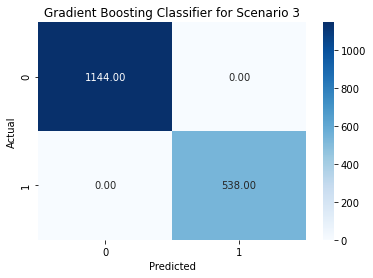

In [100]:
sns.heatmap(rfc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier

In [101]:
cl_result = permutation_importance(rfc_c, scl_testX1c, Y_test1c, random_state=42)

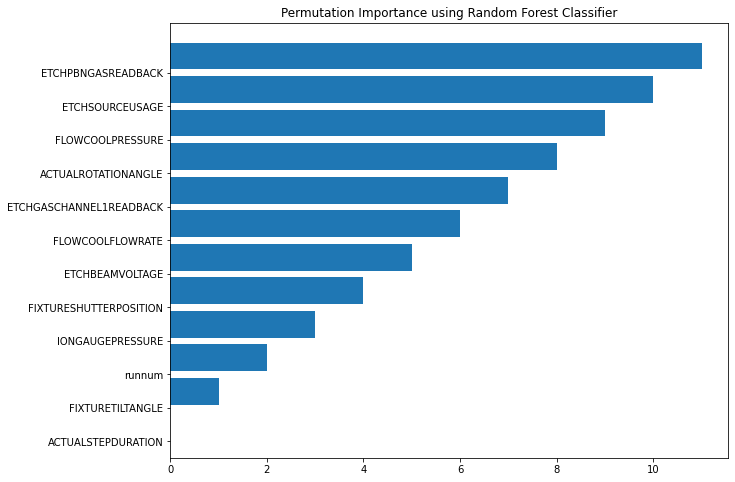

In [102]:
cl_pp = cl_result.importances_mean.argsort()

cl_sort_pp = np.argsort(cl_pp)

pos = np.arange(cl_sort_pp.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1c.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp[cl_sort_pp])
plt.yticks(y_ticks, cl_X1c.columns[cl_sort_pp])
plt.title('Permutation Importance using Random Forest Classifier')
plt.show()

#### Gradient Boost Classifier C

In [103]:
gbc_c = GradientBoostingClassifier()

gbc_c.fit(scl_trainX1c, Y_train1c)

GradientBoostingClassifier()

In [104]:
gbc_pred_c = gbc_c.predict(scl_testX1c)

gbc_accuracy_c = accuracy_score(Y_test1c, gbc_pred_c)

print('Accuracy Score Gradient Boost Classifier Scenario 3: {:.3f}\n'.format(gbc_accuracy_c))
print('Classification Report Gradient Boost Classifier Scenario 3\n\n', classification_report(Y_test1c, gbc_pred_c))

Accuracy Score Gradient Boost Classifier Scenario 3: 0.999

Classification Report Gradient Boost Classifier Scenario 3

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1144
           1       1.00      1.00      1.00       538

    accuracy                           1.00      1682
   macro avg       1.00      1.00      1.00      1682
weighted avg       1.00      1.00      1.00      1682



In [105]:
gbc_cm_c = confusion_matrix(Y_test1c, gbc_pred_c)

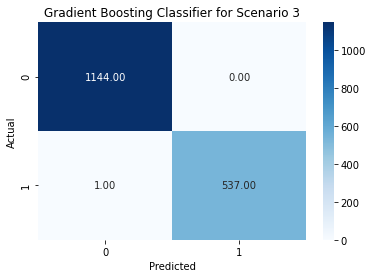

In [106]:
sns.heatmap(gbc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression C

In [107]:
logreg_c = LogisticRegression()

logreg_c.fit(scl_trainX1c, Y_train1c)

LogisticRegression()

In [108]:
logreg_pred_c = logreg_c.predict(scl_testX1c)

logreg_accuracy_c = accuracy_score(Y_test1c, logreg_pred_c)

print('Accuracy Score Logistic Regression Scenario 3: {:.3f}\n'.format(logreg_accuracy_c))
print('Classification Report Logistic Regression Scenario 3\n\n', classification_report(Y_test1c, logreg_pred_c))

Accuracy Score Logistic Regression Scenario 3: 0.838

Classification Report Logistic Regression Scenario 3

               precision    recall  f1-score   support

           0       0.83      0.95      0.89      1144
           1       0.86      0.59      0.70       538

    accuracy                           0.84      1682
   macro avg       0.85      0.77      0.80      1682
weighted avg       0.84      0.84      0.83      1682



In [109]:
logreg_cm_c = confusion_matrix(Y_test1c, logreg_pred_c)

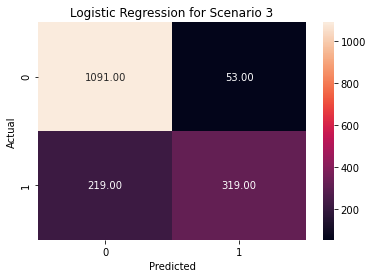

In [110]:
sns.heatmap(logreg_cm_c, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation C

In [111]:
rfc_valscore_c = cross_validate(rfc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_c['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].std()))

Scores:
 [1.         1.         0.99888765 0.99889012 0.99888765]
Scores:0.999
Scores:0.001


In [112]:
gbc_valscore_c = cross_validate(gbc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_c['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].std()))

Scores:
 [0.99888765 0.99888765 0.99888765 0.99888765 0.99888765]
Scores:0.999
Scores:0.000


In [140]:
logreg_valscore_c = cross_validate(logreg_c, scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_c['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].std()))

Scores:
 [0.69779507 0.6953125  0.76752768 0.71887035 0.72727273]
Scores:0.721
Scores:0.026


## Scenario 4: 86400 and failure is 20000 - 24 hours, about 51/2 hours

In [113]:
cl_f1d_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit', 'TTF_Flowcool_leak',
                       'fault1_a', 'fault1_b','fault1_c'], axis=1)

In [114]:
clf1data_d = cl_f1d_data.dropna()

In [115]:
cutoff_1d = 86400

cl_cutoff1d = clf1data_d.loc[clf1data_d['Flowcool_Pressure_Too_High']<cutoff_1d].copy()

In [116]:
cl_X1d = cl_cutoff1d.drop(['Flowcool_Pressure_Too_High', 'fault1_d'], axis=1)
cl_Y1d = cl_cutoff1d['fault1_d']

In [117]:
cl_X1d.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
1347545,11090833,-0.079460,-0.958985,-2.840944,-2.332807,-1.753413,-2.791223,2.027848,-0.122428,0.0,-0.283982,4.037785
1347546,11090833,-0.079442,-0.958587,-2.840944,-2.332807,-1.753413,-2.791223,2.027848,-0.122428,0.0,-0.283982,4.037785
1347547,11090833,-0.079433,-0.959099,-2.840944,-2.332807,-1.754914,-2.791223,2.027848,-0.122428,0.0,-0.283982,4.037785
1347548,11090833,-0.079453,-0.958359,-2.841850,-2.332807,-1.754914,-2.788945,2.027848,-0.122428,0.0,-0.283982,4.037785
1347549,11090833,-0.079471,-0.959099,-2.841850,-2.332807,-1.754914,-2.788945,2.027848,-0.122428,0.0,-0.283982,4.037785


In [118]:
cl_Y1d.value_counts()

0    22793
1     2788
Name: fault1_d, dtype: int64

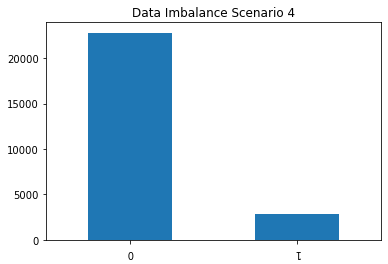

In [119]:
cl_Y1d.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 4")
plt.xticks(rotation=180)
plt.show()

In [120]:
X_train1d, X_test1d, Y_train1d, Y_test1d = train_test_split(cl_X1d, cl_Y1d, test_size = 0.2, random_state=42)

In [121]:
cl_scalar_d = MinMaxScaler()
cl_scalar_d.fit(X_train1d)

scl_trainX1d = cl_scalar.transform(X_train1d)
scl_testX1d = cl_scalar.transform(X_test1d)

#### Random Forest Classifier D

In [122]:
rfc_d = RandomForestClassifier()

rfc_d.fit(scl_trainX1d, Y_train1d)

RandomForestClassifier()

In [123]:
rfc_pred_d = rfc_d.predict(scl_testX1d)

rfc_accuracy_d = accuracy_score(Y_test1d, rfc_pred_d)

print('Accuracy Score Random Forest Classifier Scenario 4: {:.3f}\n'.format(rfc_accuracy_d))
print('Classification Report Random Forest Classifier Scenario 4\n\n',classification_report(Y_test1d, rfc_pred_d))

Accuracy Score Random Forest Classifier Scenario 4: 1.000

Classification Report Random Forest Classifier Scenario 4

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4572
           1       1.00      1.00      1.00       545

    accuracy                           1.00      5117
   macro avg       1.00      1.00      1.00      5117
weighted avg       1.00      1.00      1.00      5117



In [124]:
rfc_cm_d = confusion_matrix(Y_test1d, rfc_pred_d)

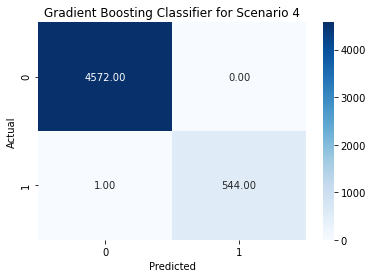

In [125]:
sns.heatmap(rfc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier D

In [126]:
cl_result_d = permutation_importance(rfc_d, scl_testX1d, Y_test1d, random_state=42)

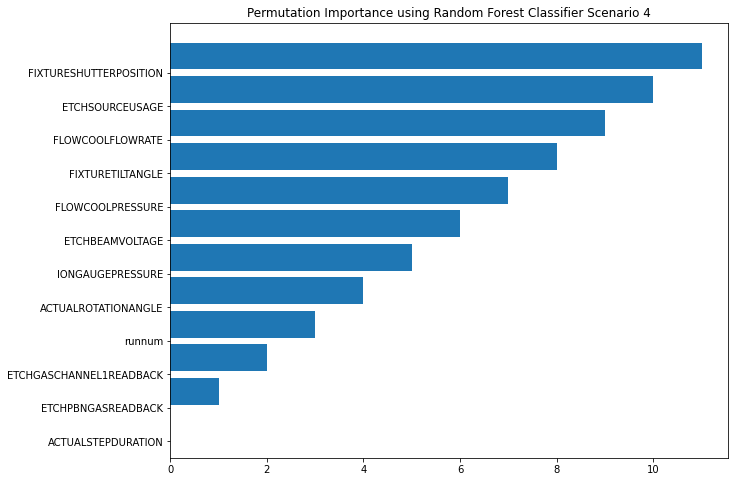

In [127]:
cl_pp_d = cl_result_d.importances_mean.argsort()

cl_sort_pp_d = np.argsort(cl_pp_d)

pos = np.arange(cl_sort_pp_d.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1d.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp_d[cl_sort_pp_d])
plt.yticks(y_ticks, cl_X1d.columns[cl_sort_pp_d])
plt.title('Permutation Importance using Random Forest Classifier Scenario 4')
plt.show()

#### Gradient Boost Classifier D

In [128]:
gbc_d = GradientBoostingClassifier()

gbc_d.fit(scl_trainX1d, Y_train1d)

GradientBoostingClassifier()

In [129]:
gbc_pred_d = gbc_d.predict(scl_testX1d)

gbc_accuracy_d = accuracy_score(Y_test1d, gbc_pred_d)

print('Accuracy Score Gradient Boost Classifier Scenario 4: {:.3f}\n'.format(gbc_accuracy_d))
print('Classification Report Gradient Boost Classifier Scenario 4\n\n', classification_report(Y_test1d, gbc_pred_d))

Accuracy Score Gradient Boost Classifier Scenario 4: 1.000

Classification Report Gradient Boost Classifier Scenario 4

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4572
           1       1.00      1.00      1.00       545

    accuracy                           1.00      5117
   macro avg       1.00      1.00      1.00      5117
weighted avg       1.00      1.00      1.00      5117



In [130]:
gbc_cm_d = confusion_matrix(Y_test1d, gbc_pred_d)

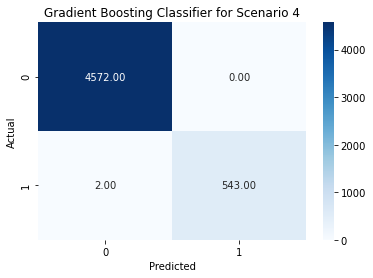

In [131]:
sns.heatmap(gbc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression D

In [132]:
logreg_d = LogisticRegression()

logreg_d.fit(scl_trainX1d, Y_train1d)

LogisticRegression()

In [133]:
logreg_pred_d = logreg_d.predict(scl_testX1d)

logreg_accuracy_d = accuracy_score(Y_test1d, logreg_pred_d)

print('Accuracy Score Logistic Regression Scenario 4: {:.3f}\n'.format(logreg_accuracy_d))
print('Classification Report Logistic Regression Scenario 4\n\n', classification_report(Y_test1d, logreg_pred_d))

Accuracy Score Logistic Regression Scenario 4: 0.939

Classification Report Logistic Regression Scenario 4

               precision    recall  f1-score   support

           0       0.95      0.99      0.97      4572
           1       0.83      0.55      0.66       545

    accuracy                           0.94      5117
   macro avg       0.89      0.77      0.81      5117
weighted avg       0.94      0.94      0.93      5117



In [134]:
logreg_cm_d = confusion_matrix(Y_test1d, logreg_pred_d)

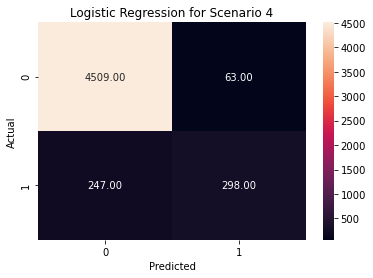

In [135]:
sns.heatmap(logreg_cm_d, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation D

In [136]:
rfc_valscore_d = cross_validate(rfc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_d['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].std()))

Scores:
 [0.99888517 1.         1.         0.99888517 1.        ]
Scores:1.000
Scores:0.001


In [137]:
gbc_valscore_d = cross_validate(gbc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_d['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].std()))

Scores:
 [1.         1.         1.         0.99776786 1.        ]
Scores:1.000
Scores:0.001


In [138]:
logreg_valscore_d = cross_validate(logreg_d, scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_d['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].std()))

Scores:
 [0.65879265 0.65389877 0.67894737 0.65940054 0.64120055]
Scores:0.658
Scores:0.012


#### Model Comparison

In [141]:
FlowcoolPressureTooHigh = pd.DataFrame({
    'Fault 2 Models':['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regression'],
       'Scenario 1':[rfc_valscore_a['test_score'].mean(),gbc_valscore_a['test_score'].mean(),logreg_valscore_a['test_score'].mean()],
       'Scenario 2':[rfc_valscore_b['test_score'].mean(),gbc_valscore_b['test_score'].mean(),logreg_valscore_b['test_score'].mean()],  
        'Scenario 3':[rfc_valscore_c['test_score'].mean(),gbc_valscore_c['test_score'].mean(),logreg_valscore_c['test_score'].mean()],
        'Scenario 4':[rfc_valscore_d['test_score'].mean(),gbc_valscore_d['test_score'].mean(),logreg_valscore_d['test_score'].mean()],
})


In [142]:
FlowcoolPressureTooHigh

,Fault 2 Models,Scenario 1,Scenario 2,Scenario 3,Scenario 4
0,Random Forest Classifier,0.992476,0.998324,0.999333,0.999554
1,Gradient Boosting Classifier,0.993367,0.997488,0.998888,0.999554
2,Logistic Regression,0.561766,0.794380,0.721356,0.658448


#### SMOTEENN

SMOTTEENN applied to Scenario 1 to improve the performance of the Logistic Regression.

In [143]:
smote = SMOTEENN()

X_res, Y_res = smote.fit_resample(scl_trainX1a, Y_train1a.ravel())
X_res_test, Y_res_test = smote.fit_resample(scl_testX1a, Y_test1a.ravel())

In [144]:
smote_rfc = LogisticRegression(max_iter=300)

smote_rfc.fit(X_res, Y_res)

LogisticRegression(max_iter=300)

In [145]:
smote_pred = smote_rfc.predict(X_res_test)

smote_rf_accuracy = accuracy_score(Y_res_test, smote_pred)

print('Accuracy Score Logistic Regression after SMOTEENN Scenario 1: {:.3f}\n'.format(smote_rf_accuracy))
print('Classification Report after SMOTEENN Scenario 1 \n\n', classification_report(Y_res_test, smote_pred))

Accuracy Score Logistic Regression after SMOTEENN Scenario 1: 0.804

Classification Report after SMOTEENN Scenario 1 

               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1076
           1       0.82      0.78      0.80      1113

    accuracy                           0.80      2189
   macro avg       0.80      0.80      0.80      2189
weighted avg       0.81      0.80      0.80      2189



**Note** Even though the overall performance of the Logistic Regression decreased the f1-score in prediciting isfailure significantly improved. 

In [146]:
logreg_smote_a = confusion_matrix(Y_res_test, smote_pred)

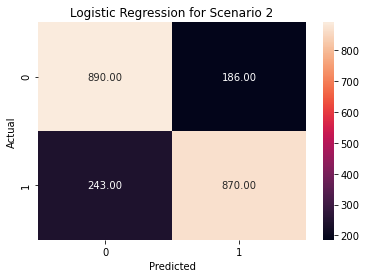

In [147]:
sns.heatmap(logreg_smote_a, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()